# Sieć neuronowa

Od tego mementu wkraczamy w bardziej złożone modele i ich implementacha od podstaw wymaga znajomości wielu detali technicznych (np. cachowanie wartości funkcji aktywacji nodów podczas forward propagation), jeśli ktoś jest ambitny polecam zrobić cały program w pythonie do uczenia sieci neuronowej (po krótce: inicjalizacja parametrów, forward pass, backward pass) jako projekt z tematyki ML.
<br> <br>
Ponieważ nie zdążymy przejść przez szczegóły od tego momentu będziemy korzystać z tych modeli jak z "black-box" - będzie nas interesowała ich poprawna architektura, wymiar wejść, wymiar wyjść, dane treningowe. Te bardzo szczegółowe operacje jak iteracyjne uczenie oddamy w ręce popularnych bibliotek do deep learningu (np. keras). Oczywiście absolutny brak zrozumienia co się dzieje pod podszewką takich modeli jest niewskazany i dlatego postaramy się zrozumieć chociaż pewne koncepty, intuicje związane z tymi modelami - będą one pokazywane na slajdach.
<br><br>
W tym zadaniu nadal będziemy zajmować się naszym problemem rozpoznawania czy na zdjęciu jest kot czy go nie ma - podobnie jak w zadaniu regresji logistycznej.

## Ściągnięcie bibliotek i danych

In [ ]:
import sys
# !conda install --yes --prefix {sys.prefix} -c anaconda pydot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1 import reset_default_graph
import cv2
import random
import urllib
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Activation
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import plot_model
import os

from utils import decrypt_pickle, SelectFilesButton, bcolors

#### Ściągnięcie danych

In [ ]:
all_data = decrypt_pickle('catvsnotcat.pkl.aes', password=None)

#### Zrzutowanie wszystkich zdjęć do założonego wymiaru

Proszę w pętli za pomocą biblioteki cv2 oraz funkcji resize zrzutować wszystkie zdjęcia (w elemencie listy pod kluczem 'X') z naszego zbioru do określonego rozmiaru i zapisać je do nowej list *all_data_processed* wraz z flagą (pod kluczem 'Y') zmienioną na wartości 0 i 1 zgodnie ze słownikiem *label_dict* poniżej

In [ ]:
IMG_SIZE = 64
label_dict = {'cat': 1, 'not-cat': 0}
all_data_processed = []


In [ ]:
number_of_examples = len(all_data)
let_know = int(number_of_examples / 10)

for idx, example in enumerate(all_data):
    if (idx+1)%let_know == 0:
        print(f'processing {idx + 1}')
    resized_down = cv2.resize(example['X'], (IMG_SIZE, IMG_SIZE), interpolation= cv2.INTER_LINEAR)
    
    all_data_processed.append({'X': np.array(resized_down), 'Y': label_dict[example['Y']]})

Zobaczmy kilka zdjęć naszego zbioru

In [ ]:
classNames = {value:key for key, value in label_dict.items()}
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(18,12))
axes = axes.flatten()
number_of_examples = len(all_data_processed)
for idx, axis in enumerate(axes):
    idx = random.randint(0, number_of_examples)
    example = all_data_processed[idx]
    axis.axis('off')
    axis.set_title(f"{classNames[example['Y']]}")
    axis.imshow(example['X'])

**Proszę o losowe przemieszanie listy danych**

In [ ]:
random.seed(42)
# proszę kontynuować kod

In [ ]:
X = np.array([example['X'] for example in all_data_processed])
Y = np.array([example['Y'] for example in all_data_processed])
print(f"{bcolors.BOLD}Rozmiar cech (X): {X.shape}, rozmiar flagi/indykatora klasy (Y): {Y.shape}{bcolors.ENDC}")

##### Proszę kontynuować kod i stworzyć podzbiory
Po tych wszystkich analizach możemy w końcu podzielić nasze dane na zbiór treningowy i testowy.

In [ ]:
split_ratio = 0.6
split_idx = int(len(Y)*split_ratio)
ohe = OneHotEncoder()
Y = ohe.fit_transform(Y.reshape(-1,1))
# proszę zadeklarować poniższe zmienne korzystając z macierzy X i Y (podpowiedź: slice):
X_train = None
X_test = None
Y_train = None
Y_test = None

Przypominam tylko, że jest gotowa funkcja do podziału na zbiór treningowy i testowy - w przyszłości polecam stosować (na razie proszę podzielić te próbkę ręcznie)<br>
from sklearn.model_selection import train_test_split

Teraz "rozplączemy" macierze zdjęć 64x64x3 na długie wektory tworząc *X_train_flat* oraz *X_test_flat*

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
Y_train = Y_train.todense()
Y_test = Y_test.todense()

print ("X_train_flat shape: " + str(X_train_flat.shape))
print ("X_test_flat shape: " + str(X_test_flat.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("Y_test shape: " + str(Y_test.shape))

Zostawimy również zdjęcia w postaci macierzy trzywymiarowej (3D) aby wykorzystać w modelu sieci neuronowej przystosowanej do otrzymywania pełnych, a nie zrzutowanych do jednego wektora, obrazków

In [ ]:
print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))

**Proszę znormalizować dane treningowe i testowe** (_flat)

## Feed Forward Neural Network

Poniżej stworzymy architekturę pierwszej sieci neuronowej - jest to sieć pełnych połączeń (Feed Forward Neural Network). Wykorzystamy do tego bibliotekę keras i funkcjonalność *Sequential()* aby zbudować kolejne warstwy sieci.<br><br> 
Sieć jest w pewnym sensie kilkoma ułożonymi w warstwy regresjami logistycznymi (tylko często używamy innej funkcji aktywacji niż sigmoida) - czyli np. wyjścia pierwszej regresji logistycznej (pierwszej warstwy) są wejściami dla drugiej regresji logistycznej (drugiej warstwy).<br><br>
Deep Learningiem (uczeniem głębokim) nazywami struktury w których występuje właśnie taka hierarchia, łańcuch, warstwy. Główną ideą za tym stojącą jest przypuszczenie, że taki model wyuczy się pewnych meta-cech w warstwach pośrednich/ukrytych. Na przykład, być może sieć uczona na danych dotyczących mieszkań (regresja liniowa) stworzyłaby metacechę oznaczającą jak przestrzenne jest mieszkanie - być może jakiaś kombinacja cech wejściowych "wytworzy" taką meta-cechę. Musimy jednak pamiętać, że raczej nie jesteśmy w stanie "odczytać" tych metacech ani ręcznie ich ustawić.<br><br>
**Proszę napisać następującą sieć w keras:**
 - warstaw gęsta, 4096 neuronów, funkcja aktywacji ReLU, inicjalizacja rozkładem jednostajnym, podanie rozmiaru wejścia
 - warstaw gęsta, 512 neuronów, funkcja aktywacji ReLU, inicjalizacja rozkładem jednostajnym
 - warstaw gęsta, liczba neuronów równa liczbie klas
 - dodanie funkcji aktywacji softmax

In [ ]:
reset_default_graph()


In [ ]:
model.summary()

**Rozwiązanie:**
<div>
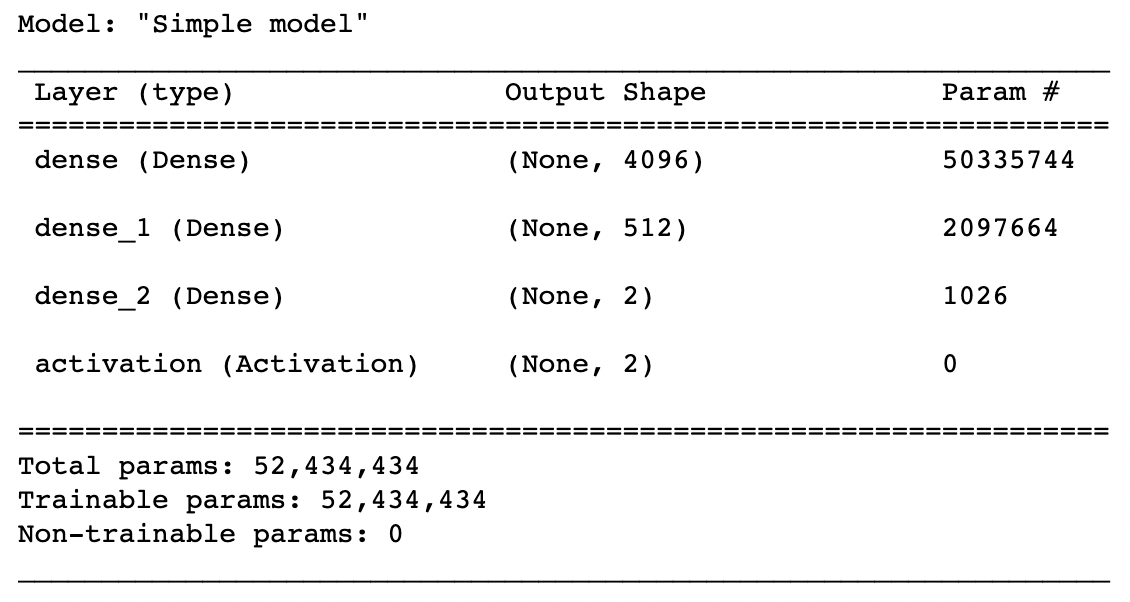
</div>

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

**Rozwiązanie:**
<div>
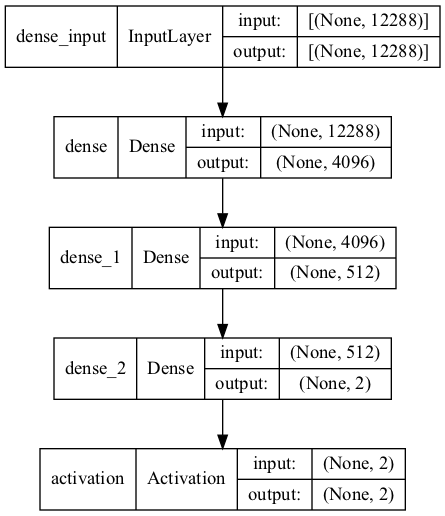
</div>

Powyżej zadeklarowaliśmy architekturę naszej sieci (warstwy, neurony, funkcje aktywacji itd.), jednak aby model mógł się uczyć musimy podać jeszcze szczegóły dotyczące iteracyjnego poruszania w stronę gradientu.<br>
**Uzupełnić model.compile z kosztem binary_crossentropy, optimizerem Adam i podaniem metryki accuracy**<br>
**Uzupełnić model.fit odpowiednimi danymi, liczbą epok 50, batch size na 64, danymi validacyjnymi, verbose ustawić na 1, a callback na listę tensorboard_callback**

In [ ]:
log_dir = os.path.join('logs','model', datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



**Pod koniec uczenia dokładność (accuracy) dla zbioru treningowego powinna być powyżej 90% zaś dla zbioru testowego (val) około 70%.**
<br><br>
Poniżej wyrysujemy wykres dokładności (accuracy) zbioru treningowego i testowego w zależności od epok/czasu uczenia. Proszę zauważyć, że od pewnego momentu to raczej dokładność na zbiorze treningowym rośnie a na testowym stoi w miejscu - być może następuje overfitting.
<br><br>
**Dla chętnych**<br>
Ponieważ zapisaliśmy logi do odpowiedniego foldera możemy też zobaczyć jak wygląda tensorboard przez wywołanie komendy w terminalu (oczywiście będąc w odpowiednim folderze):
<br>
<blockquote> tensorboard --logdir=logs/model </blockquote>
<br>
Powyższa komenda poda nam lokalny host, który po skopiowaniu otwieramy w oknie przeglądarki internetowej

In [ ]:
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(ymin=0, ymax=1)
plt.show()

Poniżej wykres funkcji kosztu zbioru treningowego i testowego - proszą pamiętać, że uczenie modelu odbywa się poprzez iteracyjne zmniejszanie funkcji kosztu zbioru treningowego, ale model nawet nie powinien znać tej wartości dla zbioru testowego. Proszę zwrócić uwagę jak na początku funkcja kosztu zbioru testowego maleje ale po chwili zaczyna rosnąć - jest to oczywiście nieporządany skutek i najprawdopodobniej miejsce od którego zaczynamy "overfittować" model.

In [ ]:
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Dropout
Dropout jest techniką regularyzacji, która podczas uczenia losowo "ucina/zakrywa" połączenia w sieci neuronowej przez co sygnał nie będzie propagowany. Intuicja za tym stojąca mówi, że to podobnie jak nie ma dostępnych wszystkich danych - czy wprawny analityk banku będzie w stanie oszacować czy kredyt powinien być przyznany czy nie gdyby zabrakło mu jednej danej z formularza?


<div>
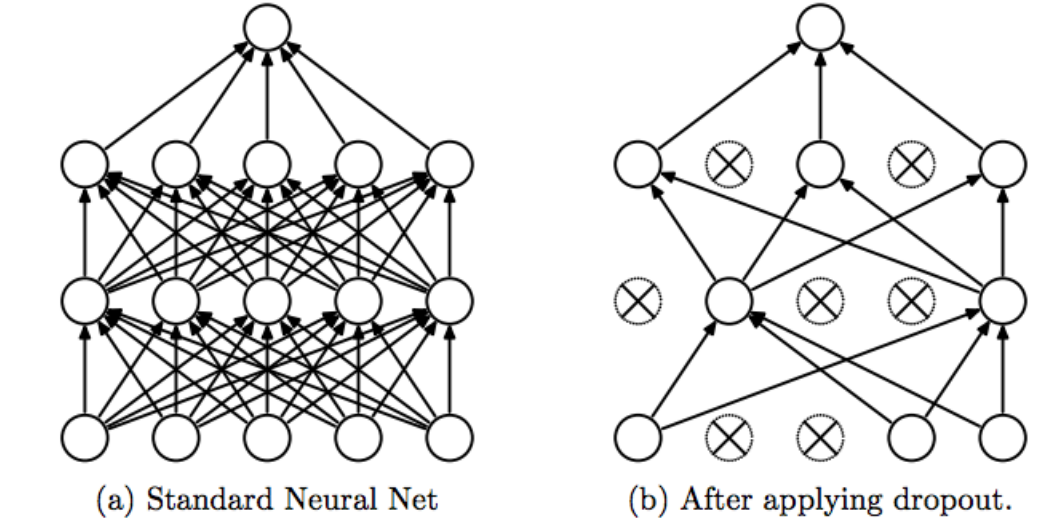
</div>

**Proszę napisać następującą sieć w keras:**
 - warstaw gęsta, 4096 neuronów, funkcja aktywacji ReLU, inicjalizacja rozkładem jednostajnym, podanie rozmiaru wejścia
 - warstwa Dropout z prawdopodobieństwem ucięcia połączenia - 0.5 czyli 50%
 - warstaw gęsta, 512 neuronów, funkcja aktywacji ReLU, inicjalizacja rozkładem jednostajnym
 - warstwa Dropout z prawdopodobieństwem ucięcia połączenia - 0.6 czyli 60%
 - warstaw gęsta, liczba neuronów równa liczbie klas
 - dodanie funkcji aktywacji softmax

In [ ]:
reset_default_graph()


In [ ]:
model_reg.summary()

**Rozwiązanie:**
<div>
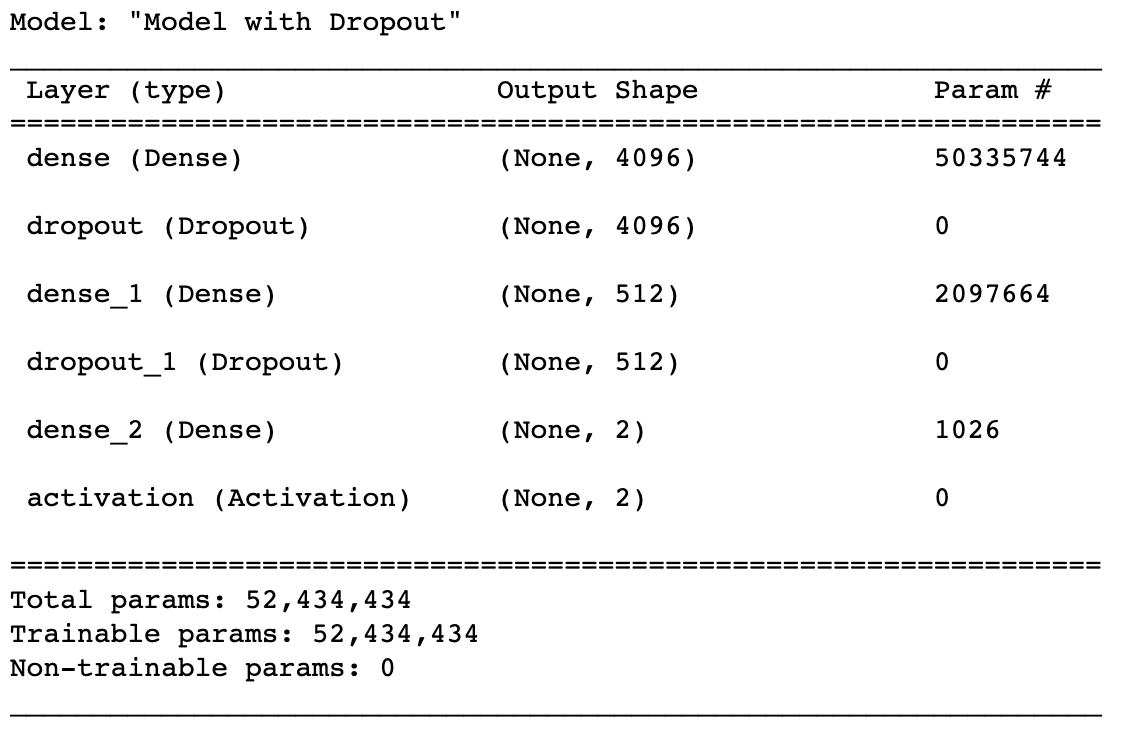
</div>

In [ ]:
plot_model(model_reg, show_shapes=True, show_layer_names=True, to_file='model_reg.png')

**Rozwiązanie:**
<div>
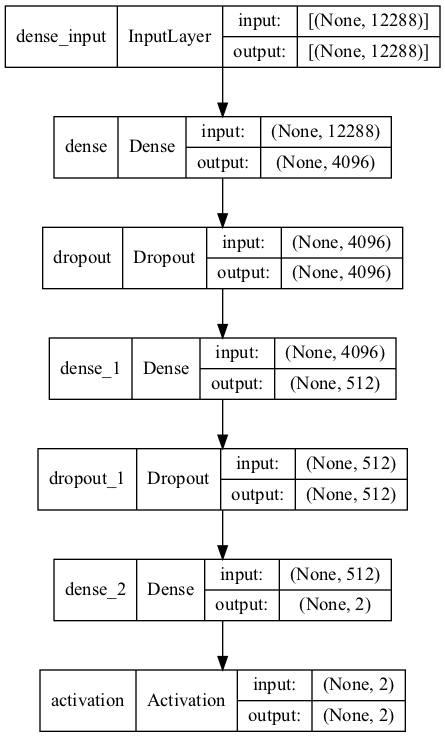
</div>

**Uzupełnić model.compile z kosztem binary_crossentropy, optimizerem SGD z krokiem 0.02 i podaniem metryki accuracy**<br>
**Uzupełnić model.fit odpowiednimi danymi, liczbą epok 50, batch size na 64, danymi validacyjnymi, verbose ustawić na 2, a callback na listę tensorboard_callback**

In [ ]:
log_dir = os.path.join('logs','regularized_model', datetime.now().strftime('%d_%m_%Y-%H_%M_%S'))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



**Pod koniec uczenia dokładność (accuracy) dla zbioru treningowego powinna być powyżej 80% zaś dla zbioru testowego (val) około 75%.**
<br><br>
Poniżej wyrysujemy wykres dokładności (accuracy) zbioru treningowego i testowego w zależności od epok/czasu uczenia. Proszę zauważyć, że rośnie dokładność na obu zbiorach i różnica w dokładności pomiędzy nimi w czasie nie jest aż tak duża jak w przypadku modelu bez dropout - to właśnie chcieliśmy osiągnąć.
<br><br>
**Dla chętnych**<br>
Ponieważ zapisaliśmy logi do odpowiedniego foldera możemy też zobaczyć jak wygląda tensorboard przez wywołanie komendy w terminalu (oczywiście będąc w odpowiednim folderze):
<br>
<blockquote> tensorboard --logdir=logs/regularized_model </blockquote>
<br>
Powyższa komenda poda nam lokalny host, który po skopiowaniu otwieramy w oknie przeglądarki internetowej

In [ ]:
fig, axes = plt.subplots(nrows=1 ,ncols=2, figsize=(20,7))

axes[0].plot(history_model_reg.history['accuracy'])
axes[0].plot(history_model_reg.history['val_accuracy'])
axes[0].set_title('regularized model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper left')
axes[0].set_ylim(ymin=0, ymax=1)

axes[1].plot(history_model.history['accuracy'])
axes[1].plot(history_model.history['val_accuracy'])
axes[1].set_title('simple model accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='upper left')
axes[1].set_ylim(ymin=0, ymax=1)
plt.show()

Poniżej porównanie funkcji kosztu dla prostego modelu NN i z regularyzają *dropout*

In [ ]:
fig, axes = plt.subplots(nrows=1 ,ncols=2, figsize=(20,7))

y_max = max(max(history_model_reg.history['loss']), max(history_model_reg.history['val_loss']), max(history_model.history['loss']), max(history_model.history['val_loss']))

axes[0].plot(history_model_reg.history['loss'])
axes[0].plot(history_model_reg.history['val_loss'])
axes[0].set_title('regularized model loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper left')
axes[0].set_ylim(ymin=0, ymax=y_max)

axes[1].plot(history_model.history['loss'])
axes[1].plot(history_model.history['val_loss'])
axes[1].set_title('simple model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='upper left')
axes[1].set_ylim(ymin=0, ymax=y_max)

plt.show()

## Konwolucyjna sieć neuronowa (CNN)

Ta architektura sieci jest jedną z najczęściej doradzanych w przypadku pracy nad obrazkami, gdyż może ona wziąć pod uwagę pewne "lokalności" znajdujące się na obrazku. Główną ideą w konwolucyjnych sieciach są tzw. filtry, które zastosowane są do wszystkich pikseli na obrazku - tzw. okno przesówne. Podczas uczenia te filtry mogą wyłapać pewne małe kształy, które później sieć może złożyć w bardziej zaawansowane struktury.<br>
Ponieważ chcemy pracować na pełnych obrazkach (macierz 3D) to weźmiemy znormalizowane dane (64x64) X_train i X_test zamiast X_train_flat i X_test_flat.<br>
Mozna sprawdzić działanie sieci konowulcyjnych pod tym linkiem: https://poloclub.github.io/cnn-explainer/

In [ ]:
print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("Y_test shape: " + str(Y_test.shape))

**Proszę znormalizować dane treningowe i testowy** (w formacie obrazu czyli macierzy 3D)

**Proszę napisać następującą sieć konwolucyjną w keras:**
 - warstaw konwolucyjna 2D, liczba filtrów 16, rozmiar filtra 3x3 funkcja aktywacji ReLU, inicjalizacja he_uniform, padding na same (ten sam), podanie rozmiaru wejścia
 - warstwa MaxPooling 2D z rozmiarem filtra 2x2
 <br><br>
 - warstaw konwolucyjna 2D, liczba filtrów 32, rozmiar filtra 3x3 funkcja aktywacji ReLU, inicjalizacja he_uniform, padding na same (ten sam)
 - warstwa MaxPooling 2D z rozmiarem filtra 2x2
 <br><br>
 - warstaw konwolucyjna 2D, liczba filtrów 64, rozmiar filtra 3x3 funkcja aktywacji ReLU, inicjalizacja he_uniform, padding na same (ten sam), podanie rozmiaru wejścia
 - warstwa MaxPooling 2D z rozmiarem filtra 2x2
 <br><br>
 - warstwa Flatten
 - warstwa Dropout z prawdopodobieństwem ucięcia połączenia - 0.3 czyli 30%
 - warstaw gęsta, 64 neuronów, funkcja aktywacji ReLU, inicjalizacja rozkładem he_uniform
 - warstwa Dropout z prawdopodobieństwem ucięcia połączenia - 0.3 czyli 30%
 - warstaw gęsta, liczba neuronów równa liczbie klas
 - dodanie funkcji aktywacji softmax

In [ ]:
reset_default_graph()


In [ ]:
model_cnn.summary()

**Rozwiązanie:**
<div>
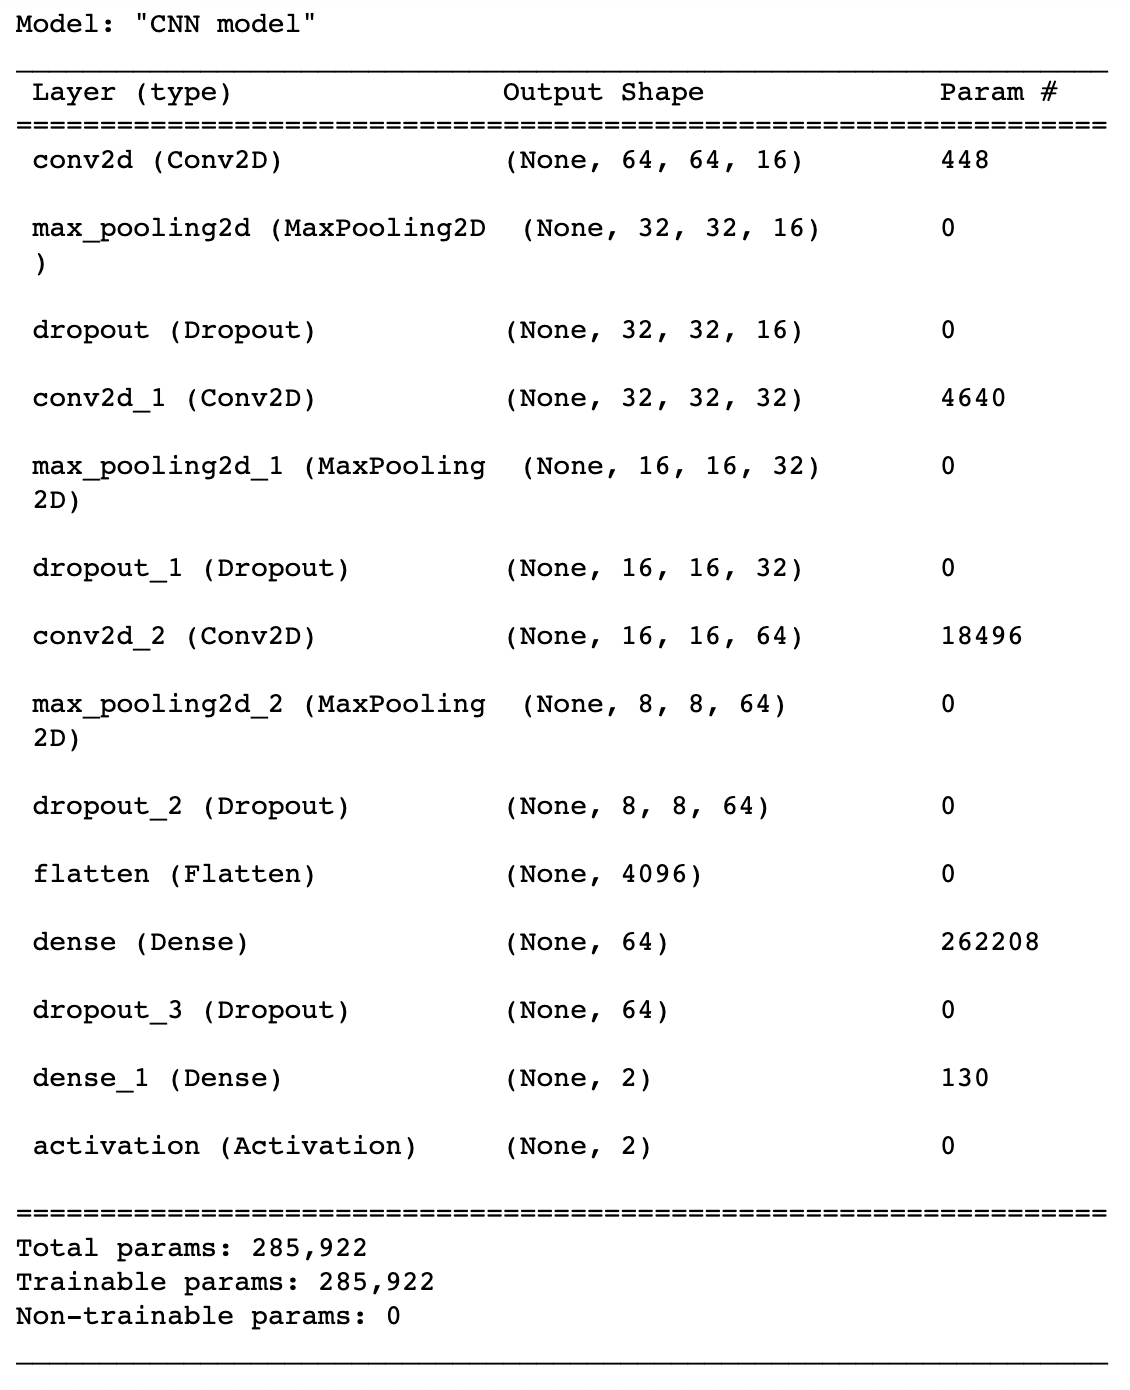
</div>

**Uzupełnić model.compile z kosztem binary_crossentropy, optimizerem Adam i podaniem metryki accuracy**<br>
**Uzupełnić model.fit odpowiednimi danymi, liczbą epok 50, batch size na 128, danymi validacyjnymi, verbose ustawić na 2, a callback na listę tensorboard_callback**

In [ ]:
log_dir = os.path.join('logs','cnn_model', datetime.now().strftime('%d_%m_%Y-%H_%M_%S'))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


**Pod koniec uczenia dokładność (accuracy) dla zbioru treningowego powinna być powyżej 90% zaś dla zbioru testowego (val) około 90%.**
<br><br>
Poniżej wyrysujemy wykres dokładności (accuracy) zbioru treningowego i testowego w zależności od epok/czasu uczenia oraz funkcji kosztu.
<br><br>
**Dla chętnych**<br>
Ponieważ zapisaliśmy logi do odpowiedniego foldera możemy też zobaczyć jak wygląda tensorboard przez wywołanie komendy w terminalu (oczywiście będąc w odpowiednim folderze):
<br>
<blockquote> tensorboard --logdir=logs/cnn_model </blockquote>
<br>
Powyższa komenda poda nam lokalny host, który po skopiowaniu otwieramy w oknie przeglądarki internetowej

In [ ]:
plt.plot(history_model_cnn.history['accuracy'])
plt.plot(history_model_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(ymin=0, ymax=1)
plt.show()

In [ ]:
plt.plot(history_model_cnn.history['loss'])
plt.plot(history_model_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Sprawdź swoje zdjęcie ##

W poniższych komórkach można podać swoje zdjęcie (z dysku lub internetu) aby na żywo dokonać predykcji za pomocą wytrenowanego modelu.
<br><br>
Poniżej proszę zakomentowywać i odkomentowywać komórki aby sprawdzić jeden z modelu - trzeba przypisać do model_inference, ten model, który chcemy sprwadzić.

In [ ]:
#proszę wybrać jeden z trzech wytrenowanych modeli poprzez odkomentowanie linijki dotyczącej wybranego modelu 
#i zakomentownie pozostalych dwóch


# model_inference = model
model_inference = model_reg
# model_inference = model_cnn


if model_inference.input.shape[1] == IMG_SIZE*IMG_SIZE*3:
    flattening = True
elif model_inference.input.shape[1] == IMG_SIZE:
    flattening = False
else:
    raise ValueError(f"{bcolors.BOLD}{bcolors.FAIL}Wykryto zły kształt wejścia do modelu: {model_inference.input.shape}{bcolors.ENDC}")

In [ ]:
my_button = SelectFilesButton()
my_button # This will display the button in the context of Jupyter Notebook

In [ ]:

if len(my_button.files) > 0:
    cols = 2 if len(my_button.files) >=2 else 1
    rows = int(np.ceil(len(my_button.files)/2))
    fig, axes = plt.subplots(nrows=rows ,ncols=cols, figsize=(18,12))
    if len(my_button.files) >=2:
        axes = axes.flatten()
    else:
        axes = [axes]
    for image, axis in zip(my_button.files, axes):
        axis.axis('off')
        
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axis.imshow(image)
        
        resized_down = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation= cv2.INTER_LINEAR)
        resized_down = resized_down / 255.
        if flattening:
            resized_down = resized_down.reshape(1, -1)
        else:
            resized_down = tf.expand_dims(resized_down, axis=0)
        predicted_classes = np.squeeze(model_inference.predict(resized_down))

        axis.set_title(f"Prediction: {classNames[np.argmax(predicted_classes)]}")
    if len(axes) > len(my_button.files):
        axes[-1].axis('off')

In [ ]:
urls = ['https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Calico_tabby_cat_-_Savannah.jpg/1200px-Calico_tabby_cat_-_Savannah.jpg'
,'https://penntoday.upenn.edu/sites/default/files/2020-02/cat-behavior-social.jpg'
]
cols = 2 if len(urls) >=2 else 1
rows = int(np.ceil(len(urls)/2))
fig, axes = plt.subplots(nrows=rows ,ncols=cols, figsize=(18,12))
if len(urls) >=2:
    axes = axes.flatten()
else:
    axes = [axes]

for photo_url, axis in zip(urls, axes):
    url_response = urllib.request.urlopen(photo_url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)

    image = cv2.imdecode(img_array, -1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axis.imshow(image)
    resized_down = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation= cv2.INTER_LINEAR)
    resized_down = resized_down / 255.
    # plt.imshow(resized_down)

    if flattening:
        resized_down = resized_down.reshape(1, -1)
    else:
        resized_down = tf.expand_dims(resized_down, axis=0)
    predicted_classes = np.squeeze(model_inference.predict(resized_down))

    axis.set_title(f"Prediction: {classNames[np.argmax(predicted_classes)]}")
    # plt.title(f"Prediction: {model_inference.predict(resized_down)}")

    axis.axis('off')

## Szkice

In [ ]:
# import tensorflow.keras.backend as K
# import csv
# import keras

# model_directory='./xyz' # directory to save model history after every epoch 

# class StoreModelHistory(tf.keras.callbacks.TensorBoard):

#     def on_epoch_end(self,batch,logs=None):
#         if ('lr' not in logs.keys()):
#             logs.setdefault('lr',0)
#             logs['lr'] = K.get_value(self.model.optimizer.lr)

#         if not ('model_history.csv' in os.listdir(model_directory)):
#             with open(model_directory+'model_history.csv','a') as f:
#                 y=csv.DictWriter(f,logs.keys())
#                 y.writeheader()

#         with open(model_directory+'model_history.csv','a') as f:
#             y=csv.DictWriter(f,logs.keys())
#             y.writerow(logs)